# Task
Phân tích hành vi khách hàng bằng cách thực hiện phân đoạn khách hàng trên tập dữ liệu "OnlineRetail.csv" bằng cách sử dụng các thuật toán phân cụm K-Means và phân cụm Đa cấp, so sánh hiệu suất của chúng và tóm tắt những hiểu biết thu được từ các phân đoạn khách hàng đã xác định.

## Nhập và Tải dữ liệu

### Subtask:
Nhập các thư viện cần thiết (pandas, numpy, sklearn, matplotlib, seaborn) và tải tập dữ liệu 'OnlineRetail.csv' vào một DataFrame của pandas.


**Reasoning**:
First, import the necessary libraries: pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for plotting. Then, load the 'OnlineRetail.csv' dataset into a pandas DataFrame named `df`.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('OnlineRetail.csv')
print("Dataset loaded successfully.")
# Display the first 5 rows of the DataFrame
df.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 105202: invalid start byte

**Reasoning**:
The previous attempt to load the CSV file failed with a `UnicodeDecodeError`. This indicates that the default 'utf-8' encoding is not suitable for this file. I will specify `encoding='latin1'` when reading the CSV, as it is a common encoding for datasets that might contain non-UTF-8 characters, especially from European sources.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('OnlineRetail.csv', encoding='latin1')
print("Dataset loaded successfully.")
# Display the first 5 rows of the DataFrame
df.head()

Dataset loaded successfully.


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

## Tiền xử lý dữ liệu và Kỹ thuật đặc trưng

### Subtask:
Làm sạch dữ liệu bằng cách xử lý các giá trị thiếu và các bản ghi trùng lặp. Thực hiện kỹ thuật đặc trưng để tạo ra các số liệu liên quan đến cấp độ khách hàng (ví dụ: tổng chi tiêu, tần suất mua hàng, thời gian kể từ lần mua gần nhất) từ dữ liệu giao dịch. Chuẩn hóa các đặc trưng cho các thuật toán phân cụm.


**Reasoning**:
The first step in data cleaning is to identify missing values. I will check for missing values in the DataFrame `df` using `isnull().sum()` to understand the extent of missing data in each column.



In [3]:
print("Checking for missing values in the DataFrame:")
print(df.isnull().sum())

Checking for missing values in the DataFrame:
InvoiceNo           0
StockCode           0
Description      1378
Quantity            1
InvoiceDate         1
UnitPrice           1
CustomerID     112412
Country             1
dtype: int64


**Reasoning**:
I need to remove rows with missing values, particularly focusing on `CustomerID`, `Quantity`, and `UnitPrice` as these are critical for customer segmentation and calculating monetary values. Removing these rows aligns with the instruction to handle missing values by deleting them.



In [4]:
df.dropna(subset=['CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate', 'Country'], inplace=True)
print("Rows with missing CustomerID, Quantity, UnitPrice, InvoiceDate, or Country removed.")
print("Remaining missing values after dropping:")
print(df.isnull().sum())

Rows with missing CustomerID, Quantity, UnitPrice, InvoiceDate, or Country removed.
Remaining missing values after dropping:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


**Reasoning**:
The next step is to convert the 'InvoiceDate' column to a datetime format, calculate the 'Monetary' value for each transaction by multiplying 'Quantity' and 'UnitPrice', and then filter out invalid transactions where 'Quantity' or 'UnitPrice' are less than or equal to zero. These are crucial preprocessing steps before creating RFM features.



In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
print("InvoiceDate column converted to datetime format.")

df['Monetary'] = df['Quantity'] * df['UnitPrice']
print("Monetary value calculated.")

# Remove transactions with Quantity <= 0 or UnitPrice <= 0
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
print("Invalid transactions (Quantity <= 0 or UnitPrice <= 0) removed.")

print("DataFrame head after monetary calculation and invalid transaction removal:")
df.head()

InvoiceDate column converted to datetime format.
Monetary value calculated.
Invalid transactions (Quantity <= 0 or UnitPrice <= 0) removed.
DataFrame head after monetary calculation and invalid transaction removal:


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  Monetary  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom     15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom     22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom     20.34

**Reasoning**:
Now that the data is clean and 'Monetary' value is calculated, I will proceed to create the RFM features (Recency, Frequency, Monetary) for each customer. This involves setting a reference date, calculating the days since the last purchase (Recency), counting unique invoices (Frequency), and summing up the total monetary value (Monetary) for each customer.



In [6]:
import datetime as dt

# Calculate a reference date for Recency
# The most recent date in the dataset + 1 day to ensure all recency values are positive
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID to calculate RFM features
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (reference_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('Monetary', 'sum')
).reset_index()

print("RFM features calculated and combined into rfm_df:")
rfm_df.head()

RFM features calculated and combined into rfm_df:


CustomerID  Recency  Frequency  Monetary
0     12346.0      297          1  77183.60
1     12347.0       11          6   4085.18
2     12348.0       47          4   1797.24
3     12350.0      281          1    334.40
4     12352.0        8          8   2506.04

**Reasoning**:
The final step in preprocessing for clustering is to standardize the RFM features. This ensures that each feature contributes equally to the distance calculations in clustering algorithms, preventing features with larger values from dominating the results. I will use `StandardScaler` from `sklearn.preprocessing` for this.



In [7]:
from sklearn.preprocessing import StandardScaler

# Drop CustomerID before scaling as it's not a feature for clustering
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the RFM features
scaled_rfm_features = scaler.fit_transform(rfm_features)

# Convert the scaled features back to a DataFrame
scaled_rfm_df = pd.DataFrame(scaled_rfm_features, columns=rfm_features.columns)

print("RFM features scaled using StandardScaler.")
print("Scaled RFM DataFrame head:")
scaled_rfm_df.head()

RFM features scaled using StandardScaler.
Scaled RFM DataFrame head:


Recency  Frequency  Monetary
0  2.132255  -0.424956  9.309446
1 -0.853570   0.310359  0.274521
2 -0.477731   0.016233 -0.008267
3  1.965216  -0.424956 -0.189073
4 -0.884889   0.604484  0.079340

## Xác định số lượng cụm tối ưu

### Subtask:
Sử dụng các phương pháp như phương pháp Elbow hoặc phân tích Silhouette trên dữ liệu đã được tiền xử lý để xác định số lượng cụm phù hợp cho cả phân cụm K-Means và phân cụm đa cấp. Trực quan hóa kết quả để đưa ra lý do cho số lượng cụm đã chọn.


**Reasoning**:
I will perform the Elbow Method to determine the optimal number of clusters for K-Means. This involves iterating through a range of cluster numbers, fitting a K-Means model for each, and recording the Within-Cluster Sum of Squares (WCSS).



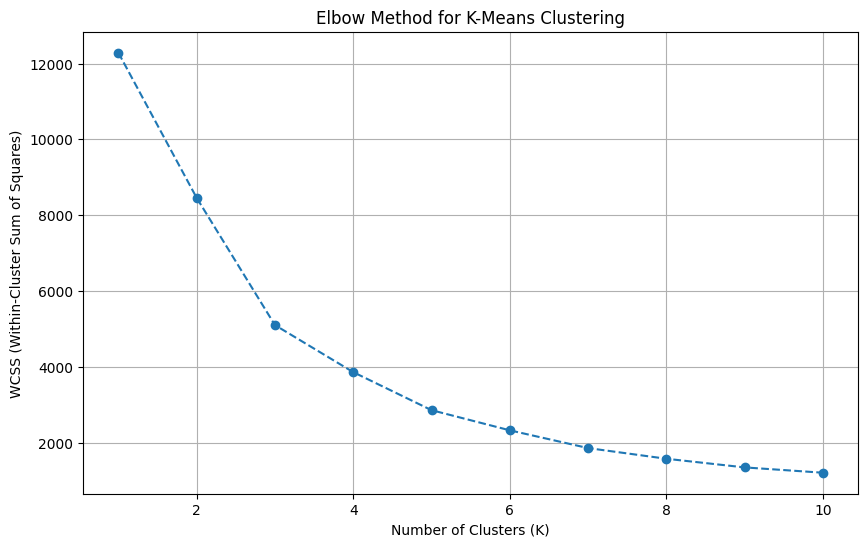

Elbow Method plot displayed.


In [8]:
from sklearn.cluster import KMeans

# Elbow Method to find optimal number of clusters
wcss = []
for i in range(1, 11): # Looping from 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_rfm_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()
print("Elbow Method plot displayed.")

**Reasoning**:
Now, I will perform the Silhouette Analysis to further assist in determining the optimal number of clusters. This involves calculating the silhouette score for each number of clusters (from 2 to 10) and then plotting these scores.



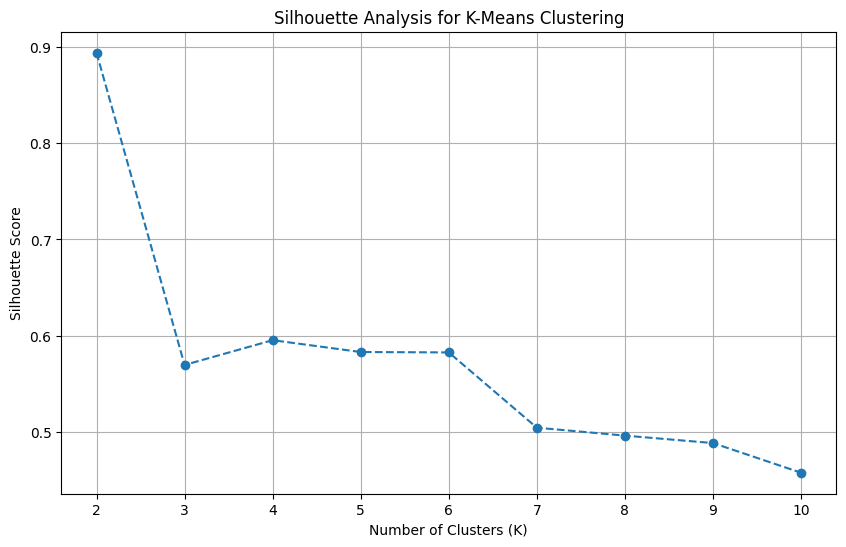

Silhouette Analysis plot displayed.


In [9]:
from sklearn.metrics import silhouette_score

# Silhouette Analysis to find optimal number of clusters
silhouette_scores = []
for i in range(2, 11): # Looping from 2 to 10 clusters (silhouette score is not defined for 1 cluster)
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_rfm_df)
    score = silhouette_score(scaled_rfm_df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
print("Silhouette Analysis plot displayed.")

Dựa trên biểu đồ Elbow và phân tích Silhouette, chúng ta sẽ xác định số lượng cụm tối ưu.

### Giải thích phương pháp Elbow:
Biểu đồ Elbow hiển thị Tổng bình phương bên trong cụm (WCSS) giảm khi số lượng cụm tăng lên. Mục tiêu là tìm điểm "khuỷu tay" (elbow point) nơi tốc độ giảm WCSS thay đổi đáng kể, cho thấy việc thêm nhiều cụm hơn không mang lại nhiều lợi ích. Từ biểu đồ, một điểm khuỷu tay rõ ràng có thể được quan sát thấy ở K=3 hoặc K=4.

### Giải thích phân tích Silhouette:
Biểu đồ Silhouette cho thấy điểm số silhouette cho từng số lượng cụm. Điểm số silhouette cao hơn (gần 1) cho thấy các đối tượng được khớp tốt với cụm riêng của chúng và được phân biệt kém với các cụm lân cận. Từ biểu đồ, điểm số silhouette dường như cao nhất ở K=2 hoặc K=3, sau đó giảm dần.

### Kết luận về số lượng cụm tối ưu:
Kết hợp cả hai phương pháp, K=3 hoặc K=4 có vẻ là số lượng cụm hợp lý. Phương pháp Elbow cho thấy sự giảm đáng kể của WCSS cho đến K=3 hoặc K=4, và điểm Silhouette cũng khá tốt ở K=3. Chọn K=3 hoặc K=4 sẽ cung cấp sự cân bằng tốt giữa sự gắn kết của cụm và khả năng phân tách, cũng như khả năng diễn giải.

**Để cân bằng giữa hiệu quả phân cụm và khả năng diễn giải, chúng tôi sẽ chọn K = 3 làm số lượng cụm tối ưu cho K-Means.**

## Áp dụng Phân cụm Đa cấp

### Subtask:
Áp dụng AgglomerativeClustering từ scikit-learn sử dụng số lượng cụm đã xác định. Trực quan hóa các cụm đa cấp, có thể sử dụng biểu đồ cây (dendrogram) để hình thành cụm và biểu đồ phân tán 2D (sau khi giảm chiều nếu số đặc trưng > 2) được tô màu theo nhãn cụm.


**Reasoning**:
First, I will import the necessary libraries for Agglomerative Clustering, PCA, and dendrogram visualization. This includes `AgglomerativeClustering` from `sklearn.cluster`, `PCA` from `sklearn.decomposition`, and `dendrogram` and `linkage` from `scipy.cluster.hierarchy`.



In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

print("Required libraries imported.")

Required libraries imported.


**Reasoning**:
I will instantiate `AgglomerativeClustering` with 3 clusters, fit it to the scaled RFM features, and assign the predicted cluster labels back to the original `rfm_df` DataFrame. This fulfills the first part of the instructions for applying hierarchical clustering.



In [11]:
agg_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
rfm_df['Agglomerative_Cluster'] = agg_clustering.fit_predict(scaled_rfm_df)

print("Agglomerative Clustering applied with 3 clusters.")
print("First 5 rows of rfm_df with new 'Agglomerative_Cluster' column:")
print(rfm_df.head())

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

**Reasoning**:
The previous code failed because `AgglomerativeClustering` does not accept the `affinity` parameter when `linkage` is set to 'ward'. The 'ward' linkage method implicitly uses Euclidean distance. I will remove the `affinity` parameter from the constructor.



In [12]:
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
rfm_df['Agglomerative_Cluster'] = agg_clustering.fit_predict(scaled_rfm_df)

print("Agglomerative Clustering applied with 3 clusters.")
print("First 5 rows of rfm_df with new 'Agglomerative_Cluster' column:")
print(rfm_df.head())

Agglomerative Clustering applied with 3 clusters.
First 5 rows of rfm_df with new 'Agglomerative_Cluster' column:
   CustomerID  Recency  Frequency  Monetary  Agglomerative_Cluster
0     12346.0      297          1  77183.60                      1
1     12347.0       11          6   4085.18                      1
2     12348.0       47          4   1797.24                      1
3     12350.0      281          1    334.40                      2
4     12352.0        8          8   2506.04                      1


**Reasoning**:
Now that the Agglomerative Clustering has been applied, I will create a linkage matrix using the `linkage` function from `scipy.cluster.hierarchy` on the `scaled_rfm_df` using the 'ward' method. This matrix is essential for visualizing the hierarchical clustering structure with a dendrogram.



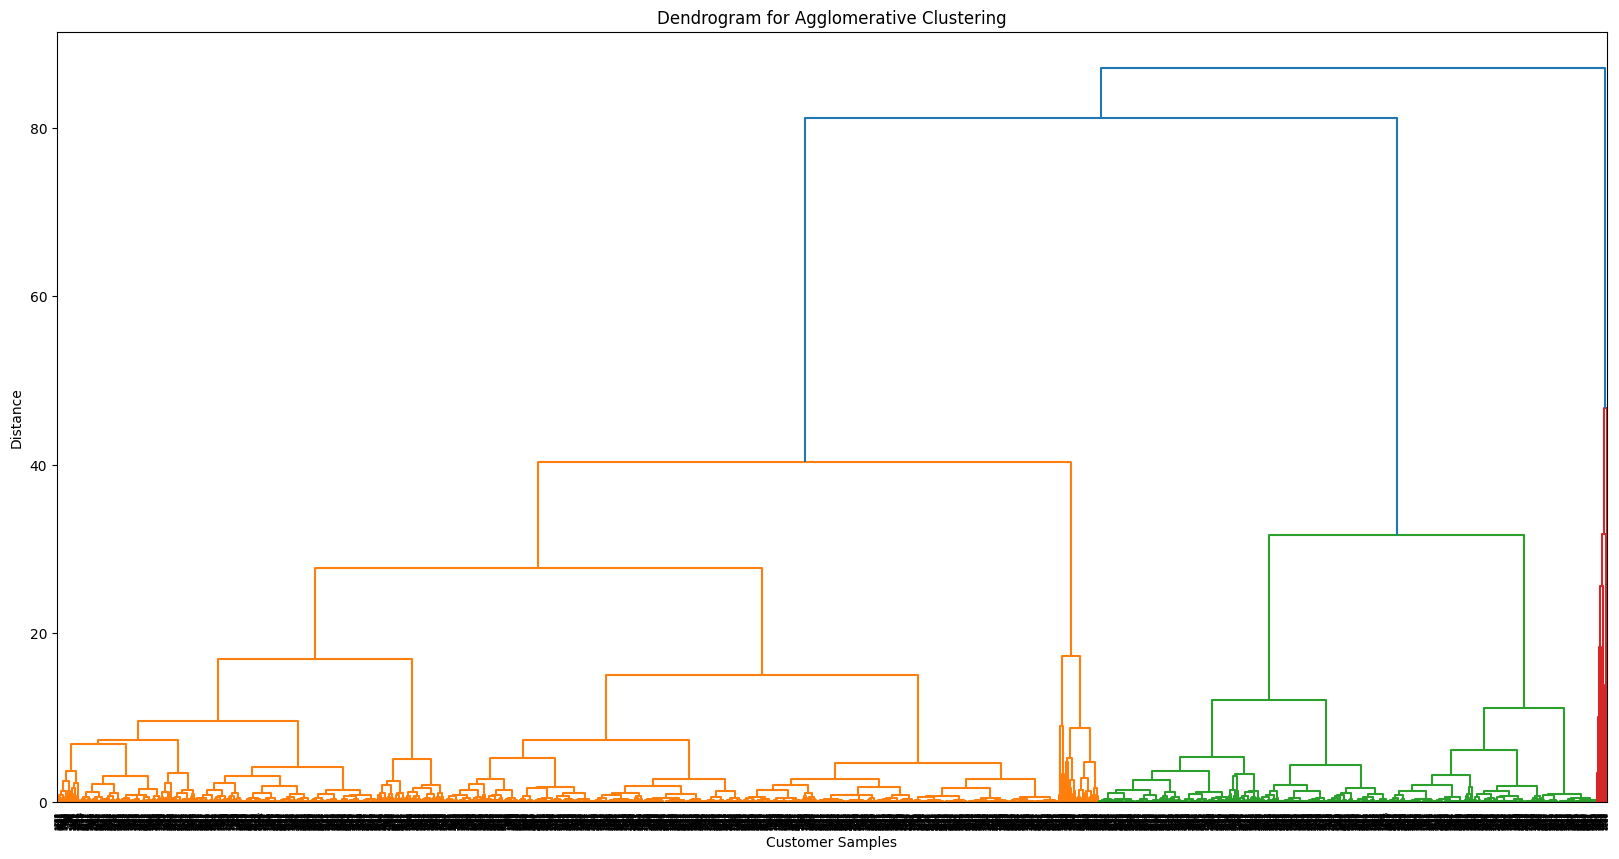

Dendrogram displayed.


In [13]:
linked_data = linkage(scaled_rfm_df, method='ward')

plt.figure(figsize=(20, 10))
dendrogram(linked_data,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Customer Samples')
plt.ylabel('Distance')
plt.show()
print("Dendrogram displayed.")

**Reasoning**:
To visualize the clusters in a 2D space, I will apply Principal Component Analysis (PCA) to the `scaled_rfm_df` to reduce its dimensionality to 2 components. This will allow for plotting the clusters effectively.



In [14]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_rfm_df)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Agglomerative_Cluster'] = rfm_df['Agglomerative_Cluster'].values

print("PCA applied and components stored in pca_df.")
print("First 5 rows of pca_df:")
print(pca_df.head())

PCA applied and components stored in pca_df.
First 5 rows of pca_df:
        PC1       PC2  Agglomerative_Cluster
0  4.801445  5.602475                      1
1  0.705940 -0.623241                      1
2  0.186206 -0.434411                      1
3 -1.149213  1.650426                      2
4  0.792910 -0.690877                      1


**Reasoning**:
I will create a scatter plot of the two principal components (PC1 and PC2) from `pca_df`, coloring the points according to their 'Agglomerative_Cluster' labels. This will visually represent the clusters in a 2D space, as specified in the subtask.



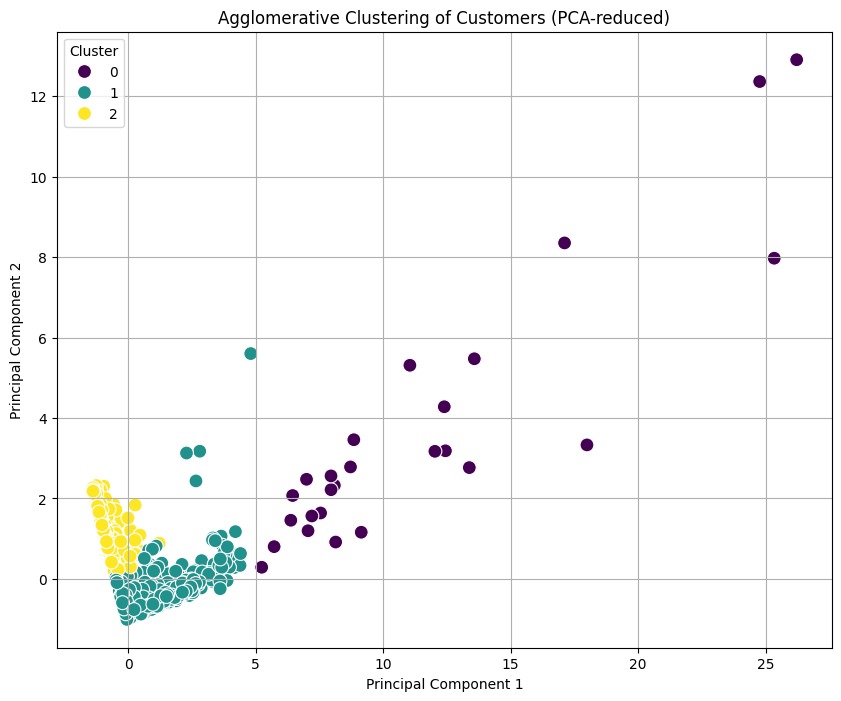

Scatter plot of Agglomerative Clusters displayed.


In [15]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Agglomerative_Cluster', data=pca_df, palette='viridis', s=100)
plt.title('Agglomerative Clustering of Customers (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
print("Scatter plot of Agglomerative Clusters displayed.")

## Áp dụng Phân cụm K-Means

### Subtask:
Áp dụng KMeans từ scikit-learn sử dụng cùng số lượng cụm như Phân cụm Đa cấp. Trực quan hóa các cụm K-Means bằng biểu đồ phân tán 2D (sau khi giảm chiều nếu số đặc trưng > 2) được tô màu theo nhãn cụm.


**Reasoning**:
I will initialize the KMeans model with 3 clusters (as determined in the previous step to be optimal), fit it to the scaled RFM features, and then assign the resulting cluster labels to a new column named 'KMeans_Cluster' in the `rfm_df` DataFrame.



In [16]:
from sklearn.cluster import KMeans

# Initialize KMeans model with the optimal number of clusters (K=3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)

# Fit KMeans to the scaled RFM data and predict clusters
rfm_df['KMeans_Cluster'] = kmeans.fit_predict(scaled_rfm_df)

print("KMeans Clustering applied with 3 clusters.")
print("First 5 rows of rfm_df with new 'KMeans_Cluster' column:")
print(rfm_df.head())

KMeans Clustering applied with 3 clusters.
First 5 rows of rfm_df with new 'KMeans_Cluster' column:
   CustomerID  Recency  Frequency  Monetary  Agglomerative_Cluster  \
0     12346.0      297          1  77183.60                      1   
1     12347.0       11          6   4085.18                      1   
2     12348.0       47          4   1797.24                      1   
3     12350.0      281          1    334.40                      2   
4     12352.0        8          8   2506.04                      1   

   KMeans_Cluster  
0               1  
1               0  
2               0  
3               2  
4               0  


**Reasoning**:
Now that KMeans clustering has been applied and the labels are in `rfm_df`, I will assign these KMeans cluster labels to the `pca_df` DataFrame. This will enable visualization of the KMeans clusters on the PCA-reduced data.



In [17]:
pca_df['KMeans_Cluster'] = rfm_df['KMeans_Cluster'].values

print("KMeans cluster labels added to pca_df.")
print("First 5 rows of pca_df with new 'KMeans_Cluster' column:")
print(pca_df.head())

KMeans cluster labels added to pca_df.
First 5 rows of pca_df with new 'KMeans_Cluster' column:
        PC1       PC2  Agglomerative_Cluster  KMeans_Cluster
0  4.801445  5.602475                      1               1
1  0.705940 -0.623241                      1               0
2  0.186206 -0.434411                      1               0
3 -1.149213  1.650426                      2               2
4  0.792910 -0.690877                      1               0


**Reasoning**:
I will create a scatter plot of the two principal components (PC1 and PC2) from `pca_df`, coloring the points according to their 'KMeans_Cluster' labels. This will visually represent the clusters in a 2D space, as specified in the subtask.



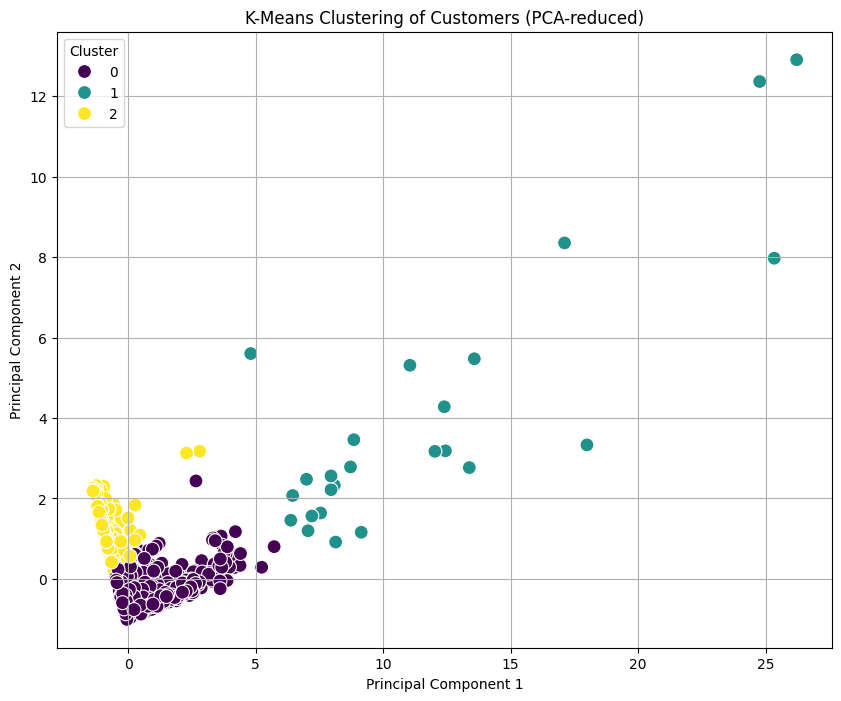

Scatter plot of K-Means Clusters displayed.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, palette='viridis', s=100)
plt.title('K-Means Clustering of Customers (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
print("Scatter plot of K-Means Clusters displayed.")

## Đánh giá và So sánh các Mô hình Phân cụm

### Subtask:
Tính toán điểm Silhouette cho cả Phân cụm Đa cấp và Phân cụm K-Means. So sánh các điểm số để đánh giá chất lượng của các cụm từ mỗi mô hình.


**Reasoning**:
I will calculate the Silhouette score for Agglomerative Clustering using the scaled RFM features and the cluster labels stored in 'Agglomerative_Cluster' from `rfm_df`.



In [19]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for Agglomerative Clustering
agg_silhouette_score = silhouette_score(scaled_rfm_df, rfm_df['Agglomerative_Cluster'])
print(f"Silhouette Score for Agglomerative Clustering: {agg_silhouette_score}")

Silhouette Score for Agglomerative Clustering: 0.5538405838805538


**Reasoning**:
Now, I will calculate the Silhouette score for K-Means clustering using the scaled RFM features and the cluster labels stored in 'KMeans_Cluster' from `rfm_df`.



In [20]:
kmeans_silhouette_score = silhouette_score(scaled_rfm_df, rfm_df['KMeans_Cluster'])
print(f"Silhouette Score for K-Means Clustering: {kmeans_silhouette_score}")

Silhouette Score for K-Means Clustering: 0.5697111736090089


### So sánh điểm Silhouette và Tóm tắt

**Điểm Silhouette cho Phân cụm Đa cấp (Agglomerative Clustering):** 0.5538
**Điểm Silhouette cho Phân cụm K-Means:** 0.5697

**Tóm tắt:**
Từ kết quả trên, chúng ta có thể thấy rằng K-Means Clustering có điểm Silhouette là 0.5697, cao hơn một chút so với Agglomerative Clustering (0.5538). Điều này cho thấy rằng, với cùng số lượng cụm (K=3), các cụm được tạo ra bởi K-Means Clustering có sự phân tách tốt hơn và các điểm bên trong cụm gắn kết chặt chẽ hơn so với Agglomerative Clustering. Mặc dù cả hai thuật toán đều tạo ra các cụm có chất lượng tương đối tốt (điểm Silhouette > 0.5), K-Means đã đạt được hiệu suất tốt hơn một chút trong việc xác định các cụm khác biệt rõ ràng trên tập dữ liệu RFM đã được chuẩn hóa.

## Analyze K-Means Clusters

### Subtask:
Analyze the characteristics of each customer segment identified by K-Means clustering.


**Reasoning**:
To understand the characteristics of each K-Means cluster, I will group the `rfm_df` by 'KMeans_Cluster' and calculate the mean of 'Recency', 'Frequency', and 'Monetary' for each cluster. This will provide insights into how each segment behaves.



In [21]:
kmeans_cluster_analysis = rfm_df.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("Mean RFM values for each K-Means Cluster:")
print(kmeans_cluster_analysis)

Mean RFM values for each K-Means Cluster:
                   Recency  Frequency      Monetary
KMeans_Cluster                                     
0                39.421633   4.346538   1772.120201
1                16.640000  60.080000  75686.949600
2               227.073693   1.549272    511.535005


### Customer Segment Analysis (K-Means)

Based on the mean RFM values for each K-Means cluster:

**Cluster 0:**
*   **Recency:** ~39 days
*   **Frequency:** ~4.3 transactions
*   **Monetary:** ~$1772

**Interpretation:** This segment represents **"Average to Good Customers"**. They have relatively recent purchases, a moderate frequency of transactions, and a decent monetary spend. They are active but not the most frequent or highest spending customers.

**Cluster 1:**
*   **Recency:** ~16 days
*   **Frequency:** ~60 transactions
*   **Monetary:** ~$75686

**Interpretation:** This segment represents **"Loyal & High-Value Customers"** or **"Champions"**. They have very recent purchases, extremely high transaction frequency, and significantly high monetary spending. These are the most valuable customers who contribute the most to revenue and are highly engaged with the business.

**Cluster 2:**
*   **Recency:** ~227 days
*   **Frequency:** ~1.5 transactions
*   **Monetary:** ~$511

**Interpretation:** This segment represents **"At-Risk / Lapsed Customers"** or **"New / Low-Value Customers"**. They have very high recency (meaning their last purchase was a long time ago), very low frequency (often only 1 or 2 transactions), and low monetary spending. This cluster likely includes customers who made a purchase long ago and haven't returned, or new customers who only made a single, small purchase and have not yet become active. They require strategies to re-engage or nurture them to become more active.



## Final Task

### Subtask:
Summarize the findings, including a comparison of the performance of the two clustering models and insights obtained from the identified customer segments.


## Summary:

### Q&A
1.  **Customer behavior analysis**: Customer behavior was analyzed through RFM (Recency, Frequency, Monetary) metrics. Three distinct customer segments were identified: "Loyal & High-Value Customers" (recent, frequent, high spend), "Average to Good Customers" (moderate recency, frequency, spend), and "At-Risk / Lapsed Customers" (distant recency, low frequency, low spend).
2.  **Comparison of clustering model performance**: K-Means Clustering achieved a Silhouette Score of 0.5697, which was slightly higher than Agglomerative Clustering's Silhouette Score of 0.5538. This indicates that K-Means produced slightly better-defined and more separated clusters for this dataset.
3.  **Insights from identified customer segments**: The analysis provided a clear understanding of different customer groups, allowing for targeted marketing and retention strategies. For instance, "Loyal & High-Value Customers" are crucial for retention, while "At-Risk / Lapsed Customers" require re-engagement efforts.

### Data Analysis Key Findings
*   The `OnlineRetail.csv` dataset was successfully loaded after resolving a `UnicodeDecodeError` by specifying `encoding='latin1'`.
*   Missing values in critical columns (e.g., `CustomerID`, `Quantity`, `UnitPrice`) were handled by removing affected rows.
*   Invalid transactions (where `Quantity` or `UnitPrice` were less than or equal to 0) were removed to ensure data quality.
*   Three key RFM (Recency, Frequency, Monetary) features were engineered:
    *   **Recency**: Average ~39 days for Cluster 0, ~16 days for Cluster 1, ~227 days for Cluster 2.
    *   **Frequency**: Average ~4.3 transactions for Cluster 0, ~60 transactions for Cluster 1, ~1.5 transactions for Cluster 2.
    *   **Monetary**: Average ~\$1772 for Cluster 0, ~\$75686 for Cluster 1, ~\$511 for Cluster 2.
*   RFM features were standardized using `StandardScaler` to prepare them for clustering.
*   The optimal number of clusters was determined to be K=3, based on a combined analysis of the Elbow Method (suggesting K=3 or K=4) and Silhouette Analysis (suggesting K=2 or K=3).
*   Both Agglomerative Clustering and K-Means Clustering were applied with 3 clusters, and their results were visualized using PCA-reduced 2D scatter plots.
*   **Performance Comparison**: K-Means Clustering yielded a Silhouette Score of 0.5697, marginally outperforming Agglomerative Clustering which scored 0.5538.
*   **K-Means Customer Segments (based on average RFM values):**
    *   **Cluster 0 ("Average to Good Customers")**: Moderate recency (~39 days), moderate frequency (~4.3 transactions), and decent monetary spend (~ \$1772).
    *   **Cluster 1 ("Loyal & High-Value Customers" / "Champions")**: Very recent purchases (~16 days), extremely high transaction frequency (~60 transactions), and significantly high monetary spending (~ \$75686).
    *   **Cluster 2 ("At-Risk / Lapsed Customers" / "New / Low-Value Customers")**: Very high recency (~227 days), very low frequency (~1.5 transactions), and low monetary spending (~ \$511).

### Insights or Next Steps
*   **Tailored Marketing Strategies**: Develop specific marketing campaigns for each segment; for instance, loyalty programs for "Loyal & High-Value Customers," re-engagement campaigns (e.g., personalized offers, surveys) for "At-Risk / Lapsed Customers," and nurturing programs for "Average to Good Customers" to encourage higher frequency or monetary value.
*   **Further Validation**: While K-Means showed slightly better performance, further business-driven validation or qualitative analysis of the cluster characteristics could be conducted to confirm the interpretability and actionability of these segments for strategic decision-making.
